<a href="https://colab.research.google.com/github/RidhaLOUZE/vision_transformers_in_pytorch_deit_140k/blob/main/vision_transformers_in_pytorch_deit_140k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()#####hada talgah fel kaggle aktab fel youtube kaggle key yna3tolk kifach telechargih aw sahel

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"roufaidahammadou","key":"2cf4ca6acd958e5206bba448f19eb3b6"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d xhlulu/140k-real-and-fake-faces

100% 3.74G/3.75G [01:05<00:00, 81.6MB/s]
100% 3.75G/3.75G [01:05<00:00, 61.5MB/s]


In [ ]:
! mkdir 140k

In [ ]:
! unzip /content/140k-real-and-fake-faces.zip -d 140k

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# We use a butterfly dataset of 50 species to demonstrate the classification method

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
import os

In [ ]:
print(len(os.listdir("/content/140k/real_vs_fake/real-vs-fake/train/fake")))
print(len(os.listdir("/content/140k/real_vs_fake/real-vs-fake/train/real")))
print(len(os.listdir("/content/140k/real_vs_fake/real-vs-fake/test/fake")))
print(len(os.listdir("/content/140k/real_vs_fake/real-vs-fake/test/real")))
print(len(os.listdir("/content/140k/real_vs_fake/real-vs-fake/valid/fake")))
print(len(os.listdir("/content/140k/real_vs_fake/real-vs-fake/valid/real")))
#im = os.listdir("/content/140k/real_vs_fake/real-vs-fake/train/real/00010.jpg")
#print(im.shape)

50000
50000
10000
10000
10000
10000


In [ ]:
## Now, we import timm, torchvision image models
!pip install timm # kaggle doesnt have it installed by default
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 16.0 MB/s 


In [ ]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import sys
from tqdm import tqdm
import time
import copy

In [ ]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [ ]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(224),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
            T.RandomErasing(p=0.2, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(224),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "valid/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [ ]:
dataset_path = "/content/140k/real_vs_fake/real-vs-fake"

In [ ]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 32, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [ ]:
classes = get_classes("/content/140k/real_vs_fake/real-vs-fake/train/")
print(classes, len(classes))

['fake', 'real'] 2


In [ ]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [ ]:
print(len(train_loader), len(val_loader), len(test_loader))

3125 625 625


In [ ]:
print(train_data_len, valid_data_len, test_data_len)

100000 20000 20000


In [ ]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

Downloading: "https://github.com/facebookresearch/deit/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth" to /root/.cache/torch/hub/checkpoints/deit_tiny_patch16_224-a1311bcf.pth


  0%|          | 0.00/21.9M [00:00<?, ?B/s]

In [ ]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((192,), ep

In [ ]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.head.parameters(), lr=0.001)

In [ ]:
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step() # step at end of epoch
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler) # now it is a lot faster
# I will come back after 10 epochs


Epoch 0/19
----------


100%|██████████| 3125/3125 [06:02<00:00,  8.62it/s]


train Loss: 0.4633 Acc: 0.8273


100%|██████████| 625/625 [01:06<00:00,  9.35it/s]


val Loss: 0.4293 Acc: 0.8536

Epoch 1/19
----------


100%|██████████| 3125/3125 [05:51<00:00,  8.88it/s]


train Loss: 0.4427 Acc: 0.8440


100%|██████████| 625/625 [01:07<00:00,  9.20it/s]


val Loss: 0.4177 Acc: 0.8621

Epoch 2/19
----------


100%|██████████| 3125/3125 [05:54<00:00,  8.83it/s]


train Loss: 0.4305 Acc: 0.8549


100%|██████████| 625/625 [01:07<00:00,  9.23it/s]


val Loss: 0.4089 Acc: 0.8690

Epoch 3/19
----------


100%|██████████| 3125/3125 [05:52<00:00,  8.88it/s]


train Loss: 0.4221 Acc: 0.8606


100%|██████████| 625/625 [01:05<00:00,  9.56it/s]


val Loss: 0.4064 Acc: 0.8710

Epoch 4/19
----------


100%|██████████| 3125/3125 [05:54<00:00,  8.83it/s]


train Loss: 0.4166 Acc: 0.8660


100%|██████████| 625/625 [01:05<00:00,  9.58it/s]


val Loss: 0.4020 Acc: 0.8764

Epoch 5/19
----------


100%|██████████| 3125/3125 [05:53<00:00,  8.83it/s]


train Loss: 0.4124 Acc: 0.8693


100%|██████████| 625/625 [01:06<00:00,  9.47it/s]


val Loss: 0.3942 Acc: 0.8808

Epoch 6/19
----------


100%|██████████| 3125/3125 [05:58<00:00,  8.72it/s]


train Loss: 0.4037 Acc: 0.8770


100%|██████████| 625/625 [01:08<00:00,  9.13it/s]


val Loss: 0.3858 Acc: 0.8886

Epoch 7/19
----------


100%|██████████| 3125/3125 [05:59<00:00,  8.69it/s]


train Loss: 0.4019 Acc: 0.8770


100%|██████████| 625/625 [01:07<00:00,  9.30it/s]


val Loss: 0.3908 Acc: 0.8827

Epoch 8/19
----------


100%|██████████| 3125/3125 [06:00<00:00,  8.66it/s]


train Loss: 0.3981 Acc: 0.8793


100%|██████████| 625/625 [01:06<00:00,  9.36it/s]


val Loss: 0.3930 Acc: 0.8801

Epoch 9/19
----------


100%|██████████| 3125/3125 [06:00<00:00,  8.66it/s]


train Loss: 0.3939 Acc: 0.8826


100%|██████████| 625/625 [01:06<00:00,  9.37it/s]


val Loss: 0.3829 Acc: 0.8919

Epoch 10/19
----------


100%|██████████| 3125/3125 [05:59<00:00,  8.70it/s]


train Loss: 0.3909 Acc: 0.8865


100%|██████████| 625/625 [01:08<00:00,  9.09it/s]


val Loss: 0.3923 Acc: 0.8800

Epoch 11/19
----------


100%|██████████| 3125/3125 [05:57<00:00,  8.73it/s]


train Loss: 0.3891 Acc: 0.8877


100%|██████████| 625/625 [01:07<00:00,  9.29it/s]


val Loss: 0.3827 Acc: 0.8931

Epoch 12/19
----------


100%|██████████| 3125/3125 [06:03<00:00,  8.60it/s]


train Loss: 0.3860 Acc: 0.8897


100%|██████████| 625/625 [01:06<00:00,  9.45it/s]


val Loss: 0.3755 Acc: 0.8998

Epoch 13/19
----------


100%|██████████| 3125/3125 [05:55<00:00,  8.79it/s]


train Loss: 0.3836 Acc: 0.8916


100%|██████████| 625/625 [01:07<00:00,  9.25it/s]


val Loss: 0.3792 Acc: 0.8930

Epoch 14/19
----------


100%|██████████| 3125/3125 [05:53<00:00,  8.85it/s]


train Loss: 0.3829 Acc: 0.8927


100%|██████████| 625/625 [01:06<00:00,  9.46it/s]


val Loss: 0.3730 Acc: 0.9000

Epoch 15/19
----------


100%|██████████| 3125/3125 [05:57<00:00,  8.75it/s]


train Loss: 0.3814 Acc: 0.8945


100%|██████████| 625/625 [01:06<00:00,  9.38it/s]


val Loss: 0.3737 Acc: 0.8993

Epoch 16/19
----------


100%|██████████| 3125/3125 [05:54<00:00,  8.81it/s]


train Loss: 0.3784 Acc: 0.8955


100%|██████████| 625/625 [01:06<00:00,  9.41it/s]


val Loss: 0.3805 Acc: 0.8945

Epoch 17/19
----------


100%|██████████| 3125/3125 [05:52<00:00,  8.85it/s]


train Loss: 0.3766 Acc: 0.8977


100%|██████████| 625/625 [01:05<00:00,  9.53it/s]


val Loss: 0.3705 Acc: 0.8999

Epoch 18/19
----------


100%|██████████| 3125/3125 [05:49<00:00,  8.95it/s]


train Loss: 0.3738 Acc: 0.8994


100%|██████████| 625/625 [01:06<00:00,  9.45it/s]


val Loss: 0.3770 Acc: 0.8980

Epoch 19/19
----------


100%|██████████| 3125/3125 [06:04<00:00,  8.58it/s]


train Loss: 0.3720 Acc: 0.9006


100%|██████████| 625/625 [01:13<00:00,  8.45it/s]

val Loss: 0.3701 Acc: 0.9031

Training complete in 141m 19s
Best Val Acc: 0.9031


## Testing

Ok, now we finished training. Lets run the dataset on the test loader and calculate accuracy

In [ ]:
# anyways, we can use model, for it is also updated witht he latest weights

In [ ]:
# our model earns 93% test accuracy, which is very high. lets save it
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model.cpu(), example)
traced_script_module.save("/content/drive/MyDrive/H5/VIT_model_140k.h5")

In [ ]:
x,y = to_cpu(dls.train.one_batch())    # notice to_cpu(...)!
activs = learn.model(x)
activs.shape

NameError: ignored

In [ ]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model.eval()

for data, target in tqdm(test_loader):
    data, target= data.cuda(), target.cuda()
    data, target = data.to(device), target.to(device)

    with torch.no_grad(): # turn off autograd for faster testing
        output = model(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

In [ ]:
x_test,y_test = next(iter(train_loader))
x_test,y_test = x_test.to(device),y_test.to(device)
y_pred = model(x_test)
print('accuracy of the model on test set : ',(((y_pred.round().reshape(-1) == y_test).sum())/float(y_pred.shape[0])).item(),"%")

In [ ]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix : ")
confusion_matrix(y_pred.round().reshape(-1).detach(),y_test)

In [ ]:
"""
Plot the training and validation loss
epochs - list of epoch numbers
loss - training loss for each epoch
val_loss - validation loss for each epoch
"""
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
"""
Plot the training and validation accuracy
epochs - list of epoch numbers
acc - training accuracy for each epoch
val_acc - validation accuracy for each epoch
"""
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [ ]:
loss = [0.4633,0.4427,0.4305,0.4221,0.4166,0.4124, 0.4037,0.4019,0.3981,0.3939,0.3909,0.3891,0.3860,0.3836,0.3829,0.3814,0.3784,0.3766 ,0.3738, 0.3720 ]
acc = [0.8273,0.8440 ,0.8549,0.8606,0.8660,0.8693,0.8770,0.8770,0.8793,0.8826,0.8865,0.8877, 0.8897,0.8916,0.8927,0.8945,0.8955,0.8977 ,0.8994 ,0.9006]
val_loss = [0.4293,0.4177,0.4089,0.4064, 0.4020,0.3942,0.3858,0.3908,0.3930, 0.3829,0.3923,0.3827,0.3755,0.3792,0.3730,0.3737,0.3805,0.3705,0.3770,0.3701]
val_acc = [0.8536,0.8621,0.8690,0.8710,0.8764,0.8808, 0.8886,0.8827,0.8801,0.8919,0.8800,0.8931,0.8998,0.8930,0.9000,0.8993,0.8945 ,0.8999,0.8980,0.9031]

In [ ]:
x = 0
for i in loss :
  if i < x :
    x = i
print(x)

y = 0
for i in acc :
  if i> y :
    y = i
print(y)

0
0.9006


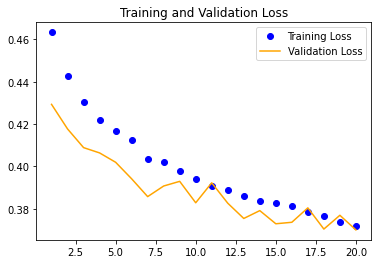

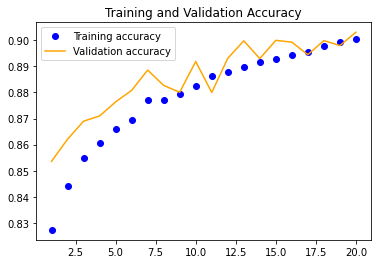

In [ ]:
plot_loss(range(1, len(loss) + 1), loss, val_loss)
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)